# Test 7 & 8: Prediction with Full Covariance Matrix for increasing problem size

In [2]:
# setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import utils
import math

import warnings

warnings.filterwarnings("ignore")

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"
mpl.rcParams.update({"font.size": 11})
mpl.rcParams.update({"errorbar.capsize": 7})
mpl.rcParams.update({"grid.linewidth": 0.5})
mpl.rcParams.update({"legend.fontsize": 9})
mpl.rcParams.update({"lines.markersize": 6})


def figsize(x, y, y_log_min=1, y_log_max=1):
    """
    Set figsize based on same bounding box to achive shared axes
    """
    x_const = 0.5847574256049264
    y_const = 0.43668402777777837
    return (
        x + x_const,
        (y + math.log10(y_log_max) - math.log10(y_log_min)) * 0.5 + y_const,
    )


# bbox = ax.get_position()
# fig_width, fig_height = fig.get_size_inches()
# print((1 - (bbox.x1 - bbox.x0)) * fig_width, (1 - (bbox.y1 - bbox.y0)) * fig_height)

In [3]:
# load data

apex_dir_pfc_gprat = "./data/7/gprat/"
apex_dir_pfc_gprat_steps = "./data/8/"
subdirs = ["apex-cpu/", "apex-gpu/"]

names_steps = [
    "predict_full_cov_step ressource allocation",
    "predict_full_cov_step assembly",
    "predict_full_cov_step cholesky",
    "predict_full_cov_step forward",
    "predict_full_cov_step backward",
    "predict_full_cov_step forward KcK",
    "predict_full_cov_step prediction",
    "predict_full_cov_step full cov",
    "predict_full_cov_step pred uncer",
    "predict_full_cov_step copyback",
    "predict_full_cov_step ressource destroy",
    "assemble K_tiles",
    "assemble alpha_tiles",
    "assemble prior_K_tiles_full",
    "assemble cross_covariance_tiles",
    "assemble t_cross_covariance_tiles",
    "assemble zeros",
    "cholesky potrf",
    "cholesky trsm",
    "cholesky syrk",
    "cholesky gemm",
    "forward trsv",
    "forward gemv",
    "backward trsv",
    "backward gemv",
    "forward_KcK trsm",
    "forward_KcK gemm",
    "predict gemv",
    "full_cov gemm",
    "pred_uncer diag_tile",
]

file_headers_cpu = ["n_cores", "n_train", "n_test", "n_tiles", "n_reg", "n_loops"]
file_headers_gpu = ["n_cores", "n_train", "n_test", "n_tiles", "n_reg", "n_streams", "n_loops"]


def apex_files_to_df(dir, names, file_headers):
    data = []
    for filename in os.listdir(dir):
        if filename.endswith(".csv"):
            parts = (
                filename.replace("apex_profiles_", "").replace(".csv", "").split("_")
            )
            file_params = dict(zip(file_headers, map(int, parts)))
            file_path = os.path.join(dir, filename)
            df = pd.read_csv(file_path)
            df = df[df["name"].isin(names)]
            for key, value in file_params.items():
                df[key] = value
            data.append(df)
    df_combined = pd.concat(data, ignore_index=True)
    df_combined = df_combined.sort_values(by=["n_train", "n_tiles"])
    return df_combined

df_pfc_gprat_steps = []

df_pfc_gprat_steps.append(
    apex_files_to_df(apex_dir_pfc_gprat_steps + subdirs[0], names_steps, file_headers_cpu)
)
df_pfc_gprat_steps.append(
    apex_files_to_df(
        apex_dir_pfc_gprat_steps + subdirs[1], names_steps, file_headers_gpu
    )
)

In [4]:
def mean_stddev(df, groupby_cols):
    new_df = df[df["i_loop"] != 0]
    new_df = (
        new_df.groupby(groupby_cols)["time"].agg(["mean", "std", "count"]).reset_index()
    )
    new_df.rename(columns={'std': 'stddev', 'count': 'n_loops'}, inplace=True)
    return new_df

In [5]:
df_gprat_cpu = pd.read_csv("./data/7/gprat/output-cpu.csv")
df_gprat_cpu = mean_stddev(df_gprat_cpu, ["n_cores", "n_train", "n_test", "n_tiles", "n_reg"])

df_gprat_gpu = pd.read_csv("./data/7/gprat/output-gpu.csv")
df_gprat_gpu = mean_stddev(df_gprat_gpu, ["n_cores", "n_train", "n_test", "n_tiles", "n_reg"])

df_pfc_gprat = [df_gprat_cpu, df_gprat_gpu]

df_gpytorch_cpu = pd.read_csv("./data/7/gpytorch/output-cpu.csv")
df_gpytorch_cpu = mean_stddev(
    df_gpytorch_cpu, ["n_cores", "n_train", "n_test", "n_reg"]
)

df_gpytorch_gpu = pd.read_csv("./data/7/gpytorch/output-gpu.csv")
df_gpytorch_gpu = mean_stddev(
    df_gpytorch_gpu, ["n_cores", "n_train", "n_test", "n_reg"]
)

df_gpytorch = [df_gpytorch_cpu, df_gpytorch_gpu]

df_gpytorch_cpu2 = pd.read_csv("./data/7/gpytorch2/output-cpu.csv")
df_gpytorch_cpu2 = mean_stddev(
    df_gpytorch_cpu2, ["n_cores", "n_train", "n_test", "n_reg"]
)

df_gpytorch_gpu2 = pd.read_csv("./data/7/gpytorch2/output-gpu.csv")
df_gpytorch_gpu2 = mean_stddev(
    df_gpytorch_gpu2, ["n_cores", "n_train", "n_test", "n_reg"]
)

df_gpytorch2 = [df_gpytorch_cpu2, df_gpytorch_gpu2]

df_gpytorch_cpu3 = pd.read_csv("./data/7/gpytorch3/output-cpu.csv")
df_gpytorch_cpu3 = mean_stddev(
    df_gpytorch_cpu3, ["n_cores", "n_train", "n_test", "n_reg"]
)

df_gpytorch_gpu3 = pd.read_csv("./data/7/gpytorch3/output-gpu.csv")
df_gpytorch_gpu3 = mean_stddev(
    df_gpytorch_gpu3, ["n_cores", "n_train", "n_test", "n_reg"]
)

df_gpytorch3 = [df_gpytorch_cpu3, df_gpytorch_gpu3]

df_gpflow_cpu = pd.read_csv("./data/7/gpflow/output-cpu.csv")
df_gpflow_cpu = mean_stddev(df_gpflow_cpu, ["n_cores", "n_train", "n_test", "n_reg"])

df_gpflow_gpu = pd.read_csv("./data/7/gpflow/output-gpu.csv")
df_gpflow_gpu = mean_stddev(df_gpflow_gpu, ["n_cores", "n_train", "n_test", "n_reg"])

df_gpflow = [df_gpflow_cpu, df_gpflow_gpu]

0       0.000478
1       0.000438
2       0.000469
3       0.000484
4       0.000530
6       0.000749
8       0.001494
10      0.003949
12      0.014369
14      0.061128
16      0.266953
18      1.444113
20      7.317172
22     42.715490
24    298.138667
Name: mean, dtype: float64
5      0.044082
7      0.043124
9      0.040665
11     0.043905
13     0.044947
15     0.048907
17     0.047530
19     0.063153
21     0.263635
23     1.932985
25    10.035265
Name: mean, dtype: float64
0     0.003425
1     0.003334
2     0.003284
4     0.003356
6     0.003244
8     0.003273
10    0.003338
12    0.003470
14    0.003782
16    0.005076
18    0.008230
20    0.021233
22    0.058425
24    0.322090
26    2.256729
Name: mean, dtype: float64
3     0.014129
5     0.014112
7     0.014414
9     0.013970
11    0.013476
13    0.013008
15    0.012673
17    0.013710
19    0.015966
21    0.028090
23    0.061435
25    0.326202
27    2.169923
Name: mean, dtype: float64


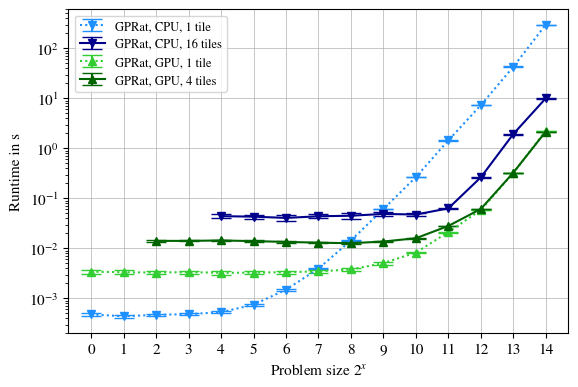

In [6]:
# plot for predict-fullcov GPRat CPU vs. GPU

plt.figure(figsize=figsize(5, 6, 2, 6))

plt.xlabel("Problem size $2^x$")
plt.ylabel("Runtime in s")
plt.grid(True, which="both")
plt.grid(False, which="minor")
plt.xscale("log", base=2)
plt.yscale("log", base=10)
plt.ylim(2 * 10**-4, 6 * 10**2)

xticks = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
plt.xticks(
    xticks,
    [f"{int(np.log2(nt))}" for nt in xticks],
)

label = r"GPRat, CPU"
ls = [(0, (1, 1.5)), "-"]
df_gprat_target = df_pfc_gprat[0]
for n_tiles, c, l in zip(
    df_gprat_target["n_tiles"].unique(), ["dodgerblue", "darkblue"], ls
):
    df_gprat_target_n_tiles = df_gprat_target[df_gprat_target["n_tiles"] == n_tiles]
    err = utils.confidence_error(df_gprat_target_n_tiles)
    plt.errorbar(
        df_gprat_target_n_tiles["n_train"],
        df_gprat_target_n_tiles["mean"],
        yerr=err,
        label=f"{label}, {n_tiles} {"tile" if n_tiles == 1 else "tiles"}",
        color=c,
        marker="v",
        linestyle=l,
    )
    print(df_gprat_target_n_tiles["mean"])

label = r"GPRat, GPU"
df_gprat_target = df_pfc_gprat[1]
for n_tiles, c, l in zip(
    df_gprat_target["n_tiles"].unique(), ["limegreen", "darkgreen"], ls
):
    df_gprat_target_n_tiles = df_gprat_target[df_gprat_target["n_tiles"] == n_tiles]
    err = utils.confidence_error(df_gprat_target_n_tiles)
    plt.errorbar(
        df_gprat_target_n_tiles["n_train"],
        df_gprat_target_n_tiles["mean"],
        yerr=err,
        label=f"{label}, {n_tiles} {"tile" if n_tiles == 1 else "tiles"}",
        color=c,
        marker="^",
        linestyle=l,
    )
    print(df_gprat_target_n_tiles["mean"])

plt.legend()
plt.tight_layout(pad=0)

plt.savefig("./pdf/predict-fullcov-inc.pdf")

0      0.001418
1      0.001573
2      0.001588
3      0.001605
4      0.002108
5      0.003336
6      0.002568
7      0.003121
8      0.006876
9      0.011617
10     0.046910
11     0.237532
12     0.850919
13     3.352289
14    14.874356
Name: mean, dtype: float64
0       0.011354
1       0.011164
2       0.011292
3       0.011265
4       0.011380
5       0.011282
6       0.011618
7       0.012336
8       0.015989
9       0.028025
10      0.085268
11      0.499455
12      3.403748
13     25.605494
14    212.206727
Name: mean, dtype: float64
0       0.000478
1       0.000438
2       0.000469
3       0.000484
4       0.000530
6       0.000749
8       0.001494
10      0.003949
12      0.014369
14      0.061128
16      0.266953
18      1.444113
20      7.317172
22     42.715490
24    298.138667
Name: mean, dtype: float64
5      0.044082
7      0.043124
9      0.040665
11     0.043905
13     0.044947
15     0.048907
17     0.047530
19     0.063153
21     0.263635
23     1.932985
25    10.

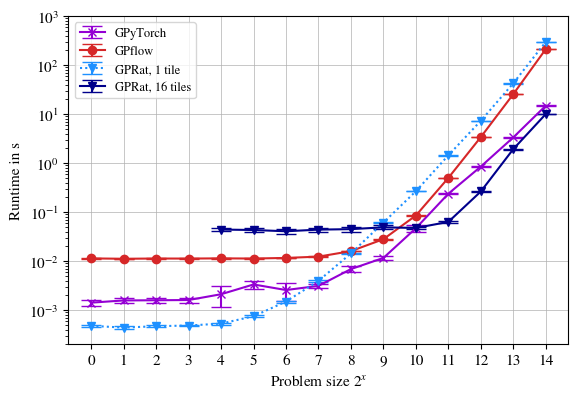

In [8]:
# plot for predict-fullcov GPRat, GPyTorch, GPflow on CPU

plt.figure(figsize=figsize(5, 6, 2, 10))

plt.xlabel("Problem size $2^x$")
plt.ylabel("Runtime in s")
plt.grid(True, which="both")
plt.grid(False, which="minor")
plt.xscale("log", base=2)
plt.yscale("log", base=10)
plt.ylim(2*10**-4, 10*10**2)

xticks = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
plt.xticks(
    xticks,
    [f"{int(np.log2(nt))}" for nt in xticks],
)

label = "GPyTorch"
df_gpytorch_target = df_gpytorch[0]
err = utils.confidence_error(df_gpytorch_target)
plt.errorbar(
    df_gpytorch_target["n_train"],
    df_gpytorch_target["mean"],
    yerr=err,
    label=label,
    color="darkviolet",
    marker="x",
)
print(df_gpytorch_target["mean"])

label = "GPflow"
df_gpflow_target = df_gpflow[0]
err = utils.confidence_error(df_gpflow_target)
plt.errorbar(
    df_gpflow_target["n_train"],
    df_gpflow_target["mean"],
    yerr=err,
    label=label,
    color="tab:red",
    marker="o"
)
print(df_gpflow_target["mean"])

label = r"GPRat"
ls = [(0, (1, 1.5)), "-"]
df_gprat_target = df_pfc_gprat[0]
for (n_tiles, c, l) in zip(
    df_gprat_target["n_tiles"].unique() , ["dodgerblue", "darkblue"], ls):
    df_gprat_target_n_tiles = df_gprat_target[df_gprat_target["n_tiles"] == n_tiles]
    err = utils.confidence_error(df_gprat_target_n_tiles)
    plt.errorbar(
        df_gprat_target_n_tiles["n_train"],
        df_gprat_target_n_tiles["mean"],
        yerr=err,
        label=f"{label}, {n_tiles} {"tile" if n_tiles == 1 else "tiles"}",
        color=c,
        marker="v",
        linestyle=l
    )
    print(df_gprat_target_n_tiles["mean"])

plt.legend()
plt.tight_layout(pad=0)

plt.savefig("./pdf/predict-fullcov-cpu-inc.pdf")

0     0.001903
1     0.002085
2     0.002100
3     0.002105
4     0.002123
5     0.002140
6     0.002139
7     0.002323
8     0.002736
9     0.003802
10    0.006607
11    0.018362
12    0.058363
13    0.289113
Name: mean, dtype: float64
0     0.013745
1     0.013922
2     0.013919
3     0.013850
4     0.013997
5     0.014056
6     0.014226
7     0.014304
8     0.014337
9     0.014683
10    0.017253
11    0.025598
12    0.066161
13    0.226215
14    1.465841
Name: mean, dtype: float64
0     0.003425
1     0.003334
2     0.003284
4     0.003356
6     0.003244
8     0.003273
10    0.003338
12    0.003470
14    0.003782
16    0.005076
18    0.008230
20    0.021233
22    0.058425
24    0.322090
26    2.256729
Name: mean, dtype: float64
3     0.014129
5     0.014112
7     0.014414
9     0.013970
11    0.013476
13    0.013008
15    0.012673
17    0.013710
19    0.015966
21    0.028090
23    0.061435
25    0.326202
27    2.169923
Name: mean, dtype: float64


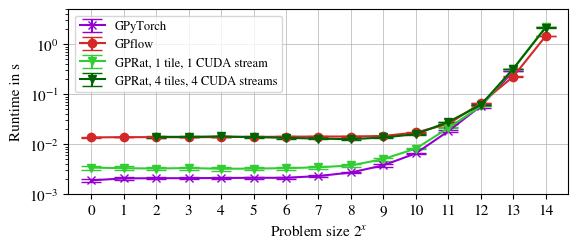

In [9]:
# plot for predict-fullcov GPRat, GPyTorch, GPflow on GPU

plt.figure(figsize=figsize(5, 3, 1, 5))

plt.xlabel("Problem size $2^x$")
plt.ylabel("Runtime in s")
plt.grid(True, which="both")
plt.grid(False, which="minor")
plt.xscale("log", base=2)
plt.yscale("log", base=10)
plt.ylim(10**-3, 5 * 10**0)

xticks = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
plt.xticks(
    xticks,
    [f"{int(np.log2(nt))}" for nt in xticks],
)

label = r"GPyTorch"
df_gpytorch_target = df_gpytorch[1]
err = utils.confidence_error(df_gpytorch_target)
plt.errorbar(
    df_gpytorch_target["n_train"],
    df_gpytorch_target["mean"],
    yerr=err,
    label=label,
    color="darkviolet",
    marker="x"
)
print(df_gpytorch_target["mean"])


label = "GPflow"
df_gpflow_target = df_gpflow[1]
err = utils.confidence_error(df_gpflow_target)
plt.errorbar(
    df_gpflow_target["n_train"],
    df_gpflow_target["mean"],
    yerr=err,
    label=label,
    color="tab:red",
    marker="o"
)
print(df_gpflow_target["mean"])

label = r"GPRat"
df_gprat_target = df_pfc_gprat[1]
labels = ["GPRat, 1 tile, 1 CUDA stream", "GPRat, 4 tiles, 4 CUDA streams"]
for n_tiles, c, label in zip(
    df_gprat_target["n_tiles"].unique(), ["limegreen", "darkgreen"], labels
):
    df_gprat_target_n_tiles = df_gprat_target[df_gprat_target["n_tiles"] == n_tiles]
    err = utils.confidence_error(df_gprat_target_n_tiles)
    plt.errorbar(
        df_gprat_target_n_tiles["n_train"],
        df_gprat_target_n_tiles["mean"],
        yerr=err,
        label=label,
        color=c,
        marker="v"
    )
    print(df_gprat_target_n_tiles["mean"])

plt.legend()
plt.tight_layout(pad=0)

plt.savefig("./pdf/predict-fullcov-gpu-inc.pdf")

0      0.001418
1      0.001573
2      0.001588
3      0.001605
4      0.002108
5      0.003336
6      0.002568
7      0.003121
8      0.006876
9      0.011617
10     0.046910
11     0.237532
12     0.850919
13     3.352289
14    14.874356
Name: mean, dtype: float64
0     0.001903
1     0.002085
2     0.002100
3     0.002105
4     0.002123
5     0.002140
6     0.002139
7     0.002323
8     0.002736
9     0.003802
10    0.006607
11    0.018362
12    0.058363
13    0.289113
Name: mean, dtype: float64


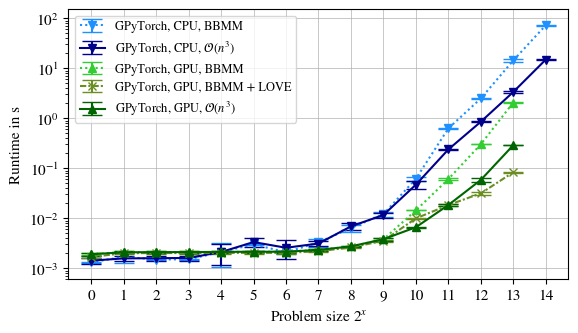

In [7]:
# plot for predict-fullcov GPRat, GPyTorch, GPflow on GPU

plt.figure(figsize=figsize(5, 5, 0.6, 1.5))

plt.xlabel("Problem size $2^x$")
plt.ylabel("Runtime in s")
plt.grid(True, which="both")
plt.grid(False, which="minor")
plt.xscale("log", base=2)
plt.yscale("log", base=10)
plt.ylim(0.6*10**-3, 1.5*10**2)

xticks = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
plt.xticks(
    xticks,
    [f"{int(np.log2(nt))}" for nt in xticks],
)


label = r"GPyTorch, CPU, BBMM"
df_gpytorch_target = df_gpytorch2[0]
err = utils.confidence_error(df_gpytorch_target)
plt.errorbar(
    df_gpytorch_target["n_train"],
    df_gpytorch_target["mean"],
    yerr=err,
    label=label,
    color="dodgerblue",
    linestyle=(0, (1, 1.5)),
    marker="v",
)

label = r"GPyTorch, CPU, $\mathcal{O}(n^3)$"
df_gpytorch_target = df_gpytorch[0]
err = utils.confidence_error(df_gpytorch_target)
plt.errorbar(
    df_gpytorch_target["n_train"],
    df_gpytorch_target["mean"],
    yerr=err,
    label=label,
    color="darkblue",
    marker="v",
)
print(df_gpytorch_target["mean"])

label = r"GPyTorch, GPU, BBMM"
df_gpytorch_target = df_gpytorch2[1]
err = utils.confidence_error(df_gpytorch_target)
plt.errorbar(
    df_gpytorch_target["n_train"],
    df_gpytorch_target["mean"],
    yerr=err,
    label=label,
    color="limegreen",
    linestyle=(0, (1, 1.5)),
    marker="^",
)

label = r"GPyTorch, GPU, BBMM + LOVE"
df_gpytorch_target = df_gpytorch3[1]
err = utils.confidence_error(df_gpytorch_target)
plt.errorbar(
    df_gpytorch_target["n_train"],
    df_gpytorch_target["mean"],
    yerr=err,
    label=label,
    color="olivedrab",
    linestyle=(0, (3, 1, 1, 1)),
    marker="x",
)

label = r"GPyTorch, GPU, $\mathcal{O}(n^3)$"
df_gpytorch_target = df_gpytorch[1]
err = utils.confidence_error(df_gpytorch_target)
plt.errorbar(
    df_gpytorch_target["n_train"],
    df_gpytorch_target["mean"],
    yerr=err,
    label=label,
    color="darkgreen",
    marker="^",
)
print(df_gpytorch_target["mean"])

plt.legend()
plt.tight_layout(pad=0)

plt.savefig("./pdf/predict-fullcov-gpytorch-inc.pdf")